<h1> Analyzing and Forecasting Rainfall (Monthly Avg) using statistical methods and Machine Learning. </h1>


The Excel file has 02 sheets (Avg and SE). Avg is the average value of the concerned parameter while SE has the standard error associated with the average value.
The file has monthly time series data from Jan 1990 to Dec 2022. The parameter in column B is rainfall (consider as Y), while indices from column C to K affect rainfall over a region (consider as X). Details of parameters from columns C to K are:

* RH_%: Relative humidity (in %)
* Dew_Point_°C: Dew point temperature (in °C)
* Cloud_Amount_%: Cloud cover fraction (in %)
* Air_T_°C: Air temperature (in °C)
* WS_m/s: Wind speed (in m/s)
* SWR_W/m2: Shortwave radiation (in W/m2)
* Soil_Mois_cum/cum: Soil moisture in the top 10 cm of soil (in cu.m/cu.m)
* Air_Pres_Pa: Air pressure (in Pa)
* ET_mm/month: Evapotranspiration (in mm/month)


* <b>Training dataset: 01 Jan 1990 to 31 Dec 2013 </b>
* <b>Validation dataset: 01 Jan 2014 to 31 Dec 2022   </b> 



We are exploring the possibilities of rainfall prediction using the SVM and random forest and other models. 
The preferred model performance indicators to use are 
* RMSE
* MAE (mean absolute error), and 
* MAPE (mean absolute percentage error).


In [1]:
#Import necessary py libraries
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error


import itertools

In [3]:
# # Dependency for excel read (One time)
# !pip install openpyxl

In [4]:
# Check working directory/ set working directory/ set input folder path

path = "P:\\IT\\Rainfall-TS-Sep2023"
print("Current working directory is set as:", path)
file_path = path+'\\input'
print("Input files are under the folder:", file_path)

#List files under input folder
os.listdir(file_path)

Current working directory is set as: P:\IT\Rainfall-TS-Sep2023
Input files are under the folder: P:\IT\Rainfall-TS-Sep2023\input


['Data_Rainfall_Prediction_USGCM.xlsx']

In [5]:
Avg = file_path+"\\Data_Rainfall_Prediction_USGCM.xlsx"


# Read the input files

df_Avg = pd.read_excel(file_path +"\\Data_Rainfall_Prediction_USGCM.xlsx", sheet_name=0)
df_SE = pd.read_excel(file_path +"\\Data_Rainfall_Prediction_USGCM.xlsx", sheet_name=1)

<h2> Descriptive Analytics on Dataset </h2>

In [6]:
df_Avg

,Month-year,Rain_mm,RH_%,Dew_Point_°C,Cloud_Amount_%,Air_T_°C,WS_m/s,SWR_W/m2,Soil_Mois_cum/cum,Air_Pres_Pa,ET_mm/month
0,1990-01-01,9.014030,29.964444,-1.340000,28.943333,19.730960,5.889429,157.799111,0.190516,99850.118606,59.103956
1,1990-02-01,31.475803,42.185556,4.015556,54.024444,20.425801,4.589979,166.008516,0.198606,99686.964186,53.675091
2,1990-03-01,17.078917,30.737778,3.087778,44.677778,24.333952,4.742352,217.592568,0.177592,99490.063841,29.731702
3,1990-04-01,2.704660,17.756667,1.768889,36.974444,31.297905,6.420676,244.281166,0.160711,98832.197942,6.528008
4,1990-05-01,16.200781,26.618889,12.231111,70.660000,35.571863,4.477367,243.126901,0.176275,98443.907152,11.553887
...,...,...,...,...,...,...,...,...,...,...,...
391,2022-08-01,188.385804,77.000000,24.718889,81.926667,29.007510,5.162503,196.557370,0.332387,98470.687835,136.274561
392,2022-09-01,253.565665,78.410000,24.028889,60.655556,28.283159,4.383535,179.436452,0.349043,98778.926774,134.123959
393,2022-10-01,127.415645,76.618889,19.396667,30.790000,24.708316,3.156706,167.869687,0.363000,99442.913650,106.765785
394,2022-11-01,0.031965,69.993333,12.811111,16.972222,20.459165,3.518426,140.425897,0.272394,99781.840553,51.961677


In [7]:
df_SE

,Month-year,Rain_mm,RH_%,Dew_Point_°C,Cloud_Amount_%,Air_T_°C,WS_m/s,SWR_W/m2,Soil_Mois_cum/cum,Unnamed: 9,ET_mm/month
0,1990-01-01,0.079583,0.644994,0.214437,2.472732,0.061176,0.031627,0.527111,0.001342,30.064191,0.889437
1,1990-02-01,0.398202,1.197770,0.098645,0.968860,0.076334,0.022232,0.685026,0.001422,30.177887,0.682230
2,1990-03-01,0.145088,2.034543,0.553396,0.936011,0.084061,0.006031,0.190514,0.001362,29.585329,0.524374
3,1990-04-01,0.107626,0.820369,0.276428,2.190209,0.064854,0.009983,0.304638,0.001412,28.733816,0.147118
4,1990-05-01,0.317898,0.337711,0.151982,2.110934,0.024254,0.005593,0.335658,0.001576,29.523641,0.477402
...,...,...,...,...,...,...,...,...,...,...,...
391,2022-08-01,1.540608,2.176294,0.260520,0.954321,0.032938,0.020541,0.239786,0.001348,29.742875,1.225524
392,2022-09-01,1.721940,2.057870,0.272690,2.969574,0.033339,0.014663,0.464107,0.002809,30.832566,1.343071
393,2022-10-01,0.838470,0.530787,0.206868,0.935739,0.015943,0.008677,0.418701,0.001878,31.214077,1.365992
394,2022-11-01,0.012082,0.961290,0.193358,2.510118,0.018776,0.017732,0.472652,0.002477,31.415346,1.013993


In [8]:
df_Avg.describe()

,Month-year,Rain_mm,RH_%,Dew_Point_°C,Cloud_Amount_%,Air_T_°C,WS_m/s,SWR_W/m2,Soil_Mois_cum/cum,Air_Pres_Pa,ET_mm/month
count,396,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,2006-06-16 13:56:21.818181760,75.453002,47.464167,11.262910,45.307045,26.709498,4.445463,186.307274,0.241711,99107.976901,64.687739
min,1990-01-01 00:00:00,0.000000,8.403333,-6.104444,5.965556,14.004320,2.599631,114.193999,0.149992,97936.988062,4.107366
25%,1998-03-24 06:00:00,7.205603,29.853611,3.116944,28.865278,21.211767,3.875586,157.861805,0.179781,98455.776532,28.527426
50%,2006-06-16 00:00:00,17.302752,44.607778,8.945000,41.230556,27.614273,4.520187,182.592483,0.209875,99163.933607,51.682022
75%,2014-09-08 12:00:00,128.241655,65.521389,21.187222,61.312778,31.526174,4.954314,215.246338,0.303251,99741.452906,103.036894
max,2022-12-01 00:00:00,465.058800,87.320000,25.921111,92.045556,37.843787,6.760548,259.506453,0.414747,100139.088155,163.326362
std,NaN,104.863389,21.234400,9.378826,22.013287,6.217932,0.795651,37.917461,0.075716,662.403859,46.333728


In [9]:
df_Avg.corr()

,Month-year,Rain_mm,RH_%,Dew_Point_°C,Cloud_Amount_%,Air_T_°C,WS_m/s,SWR_W/m2,Soil_Mois_cum/cum,Air_Pres_Pa,ET_mm/month
Month-year,1.000000,0.048172,0.155573,0.119657,-0.061645,-0.032683,-0.108719,-0.131904,0.119205,0.021967,0.065483
Rain_mm,0.048172,1.000000,0.727830,0.817442,0.799042,0.300009,0.072354,-0.029835,0.818991,-0.631598,0.767379
RH_%,0.155573,0.727830,1.000000,0.799814,0.424880,-0.142170,-0.394333,-0.451631,0.934725,-0.197367,0.879845
Dew_Point_°C,0.119657,0.817442,0.799814,1.000000,0.688347,0.459805,-0.087703,0.092514,0.849203,-0.705230,0.761668
Cloud_Amount_%,-0.061645,0.799042,0.424880,0.688347,1.000000,0.501925,0.336223,0.233488,0.526675,-0.754324,0.443870
Air_T_°C,-0.032683,0.300009,-0.142170,0.459805,0.501925,1.000000,0.461461,0.861652,0.067096,-0.893916,-0.016991
WS_m/s,-0.108719,0.072354,-0.394333,-0.087703,0.336223,0.461461,1.000000,0.596696,-0.249333,-0.441231,-0.195505
SWR_W/m2,-0.131904,-0.029835,-0.451631,0.092514,0.233488,0.861652,0.596696,1.000000,-0.232029,-0.655223,-0.241432
Soil_Mois_cum/cum,0.119205,0.818991,0.934725,0.849203,0.526675,0.067096,-0.249333,-0.232029,1.000000,-0.381739,0.944357
Air_Pres_Pa,0.021967,-0.631598,-0.197367,-0.705230,-0.754324,-0.893916,-0.441231,-0.655223,-0.381739,1.000000,-0.298291


In [10]:
df_Avg.shape

(396, 11)

In [11]:
df_Avg.isna().sum()

Month-year           0
Rain_mm              0
RH_%                 0
Dew_Point_°C         0
Cloud_Amount_%       0
Air_T_°C             0
WS_m/s               0
SWR_W/m2             0
Soil_Mois_cum/cum    0
Air_Pres_Pa          0
ET_mm/month          0
dtype: int64

In [12]:
df_Avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Month-year         396 non-null    datetime64[ns]
 1   Rain_mm            396 non-null    float64       
 2   RH_%               396 non-null    float64       
 3   Dew_Point_°C       396 non-null    float64       
 4   Cloud_Amount_%     396 non-null    float64       
 5   Air_T_°C           396 non-null    float64       
 6   WS_m/s             396 non-null    float64       
 7   SWR_W/m2           396 non-null    float64       
 8   Soil_Mois_cum/cum  396 non-null    float64       
 9   Air_Pres_Pa        396 non-null    float64       
 10  ET_mm/month        396 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 34.2 KB


<h2> Key observations on rainfall data from Descriptive analysis </h2>

* Rows, cols = (396, 11)
* DateTime is index column
* Rest are float
* 2 Parameters with negative corr wrt rainfall (rest are positive)
    1. SWR_W/m2: Shortwave radiation (in W/m2)
    2. Air_Pres_Pa: Air pressure (in Pa)
    
* No NULL value

<I> Clean data sample! 
    Good data collection and cleaning job!! 
    :) Nothing to be done here.</I>

<h2> Let's dig deep to analyse timeseries properties </h2>

In [13]:
#Some data prep
data= df_Avg.copy() #Create a copy before transformations, we can always fallback to this if something goes off
#data
# spliting date
data['year'] = data['Month-year'].dt.year 
data['month'] = data['Month-year'].dt.month
data.rename(columns={'Month-year':'date'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               396 non-null    datetime64[ns]
 1   Rain_mm            396 non-null    float64       
 2   RH_%               396 non-null    float64       
 3   Dew_Point_°C       396 non-null    float64       
 4   Cloud_Amount_%     396 non-null    float64       
 5   Air_T_°C           396 non-null    float64       
 6   WS_m/s             396 non-null    float64       
 7   SWR_W/m2           396 non-null    float64       
 8   Soil_Mois_cum/cum  396 non-null    float64       
 9   Air_Pres_Pa        396 non-null    float64       
 10  ET_mm/month        396 non-null    float64       
 11  year               396 non-null    int32         
 12  month              396 non-null    int32         
dtypes: datetime64[ns](1), float64(10), int32(2)
memory usage: 37.3 KB

<h2>Plotting Line plot for Time Series data </h2>


Please note that data is already re-sampled to Monthly average. Since, the volume column is of continuous data type, we will use line graph to visualize it. As it's 'Rain Data' we expect it to have seasonality.

In [14]:
# # If 'Date' is a column, but not the index, you can set it as the index
data.set_index('date', inplace=True)

<Axes: xlabel='month', ylabel='Rain_mm'>

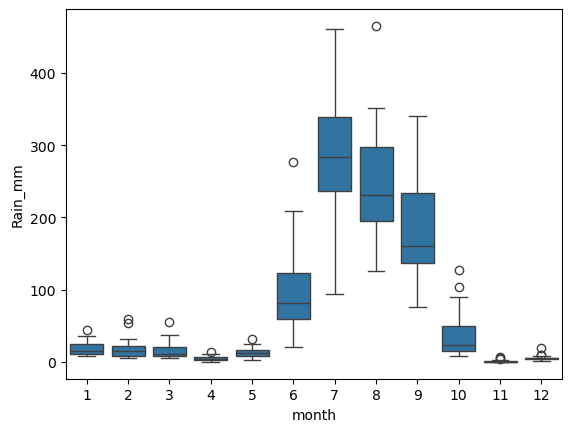

In [15]:
#See Monthly Patterns
sns.boxplot(x="month", y="Rain_mm", data=data)
#Yes, monsoon!

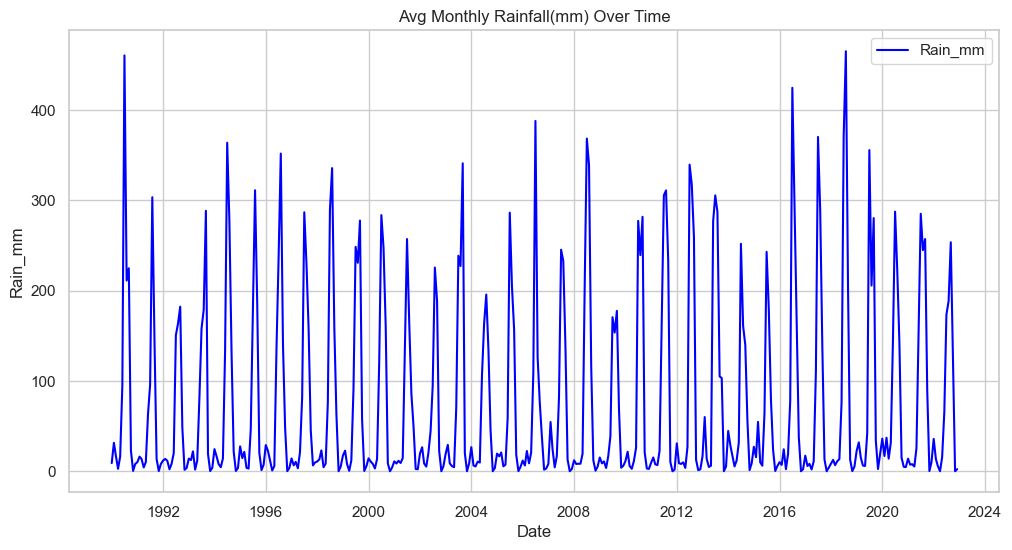

In [16]:
# Assuming df is your DataFrame
sns.set(style="whitegrid") # Setting the style to whitegrid for a clean background

plt.figure(figsize=(12, 6)) # Setting the figure size
sns.lineplot(data=data, x='date', y='Rain_mm', label='Rain_mm', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Rain_mm')
plt.title('Avg Monthly Rainfall(mm) Over Time')

plt.show()

Text(0.5, 1.0, '12 Months Moving Average')

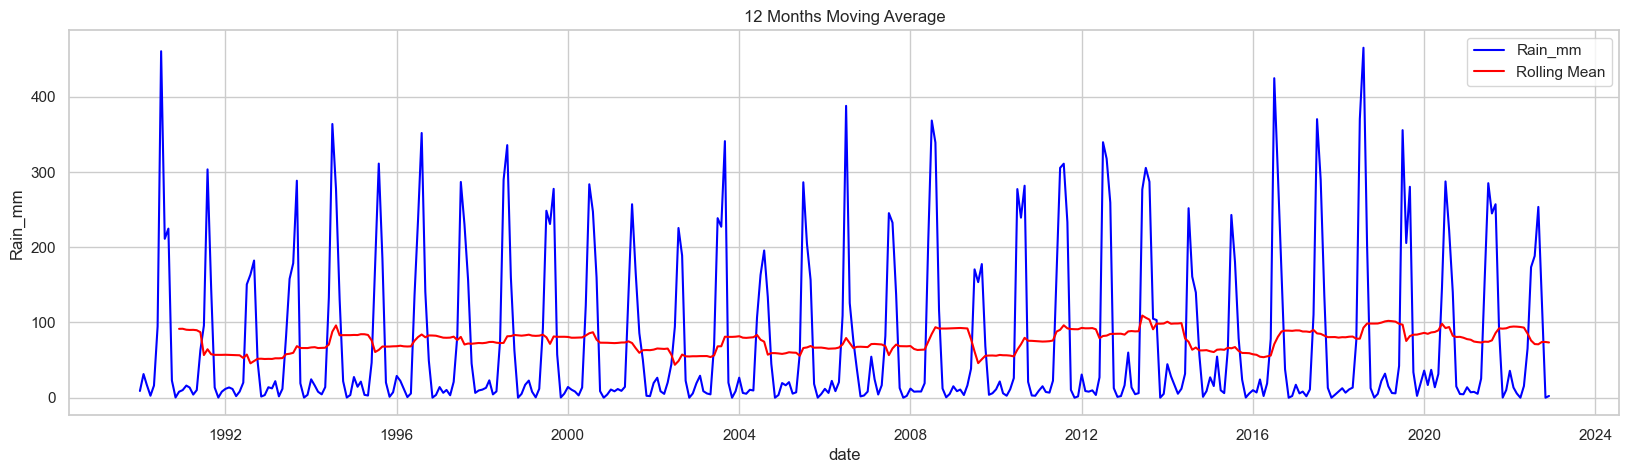

In [17]:
#12-M Moving Average

plt.figure(figsize=(20,5))
twelve_months_moving_average = data['Rain_mm'].rolling(window=12).mean()
sns.lineplot(data=data, x='date', y='Rain_mm', label='Rain_mm', color='blue')
plt.plot(twelve_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('12 Months Moving Average')

<h2> Detecting Seasonality Using Auto Correlation </h2>

We will detect Seasonality using the autocorrelation function (ACF) plot. 
Peaks at regular intervals in the ACF plot suggest the presence of seasonality.

<Figure size 1800x600 with 0 Axes>

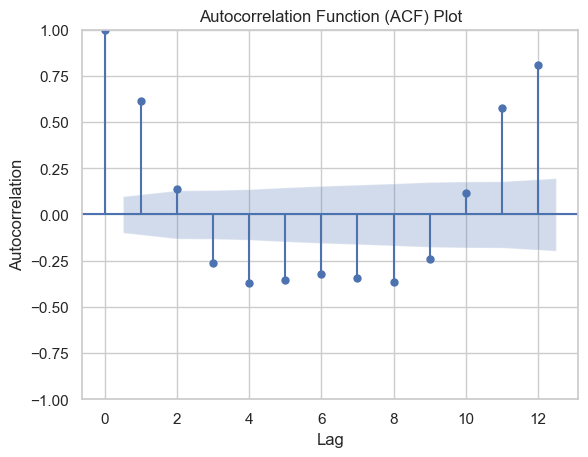

In [18]:
# Plot the ACF
plt.figure(figsize=(18, 6))
plot_acf(data['Rain_mm'], lags=12)  # As it is monthly data, a lag of 12 would represent an yearly cycle
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

We can see that we have <b> Seasonality </b> in our monthly data. (Data is also cyclic: Try lag in multiples of 12 to see visual evidence. It show resets evey 12 months.)

<h2>Detecting Stationarity</h2>

We will perform the ADF test to formally test for stationarity.

The test is based on:

* Null hypothesis that a unit root is present in the time series, indicating that the series is non-stationary.
* The alternative hypothesis is that the series is stationary after differencing (i.e., it has no unit root).
* The ADF test employs an augmented regression model that includes lagged differences of the series to determine the presence of a unit root.

In [19]:
# Assuming df is your DataFrame
result = adfuller(data['Rain_mm'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.2623600913855775
p-value: 0.0005158194038950781
Critical Values: {'1%': -3.4475850438570115, '5%': -2.869135963767125, '10%': -2.5708164748773332}


Based on the 
* ADF Stat < all Critical Values.
* p-value**: 0.0005158194038950781
So, <b>we accept the Alternate hypothesis and conclude that the data appear to be stationary </b> according to the <i>Augmented Dickey-Fuller test.</i>

* This suggests that differencing or other transformations may NOT be needed to achieve stationarity before applying certain time series models

* D-F Test we want p-value** < 0.05 to reject its null hypothesis. Based on the test which been done before, we can comfortably say that our training data is stationary.

<h2> Decompose TS</h2>

In [20]:
# Decompose the time series using the seasonal_decompose function
decomposition = seasonal_decompose(data['Rain_mm'], model='additive', period=12)

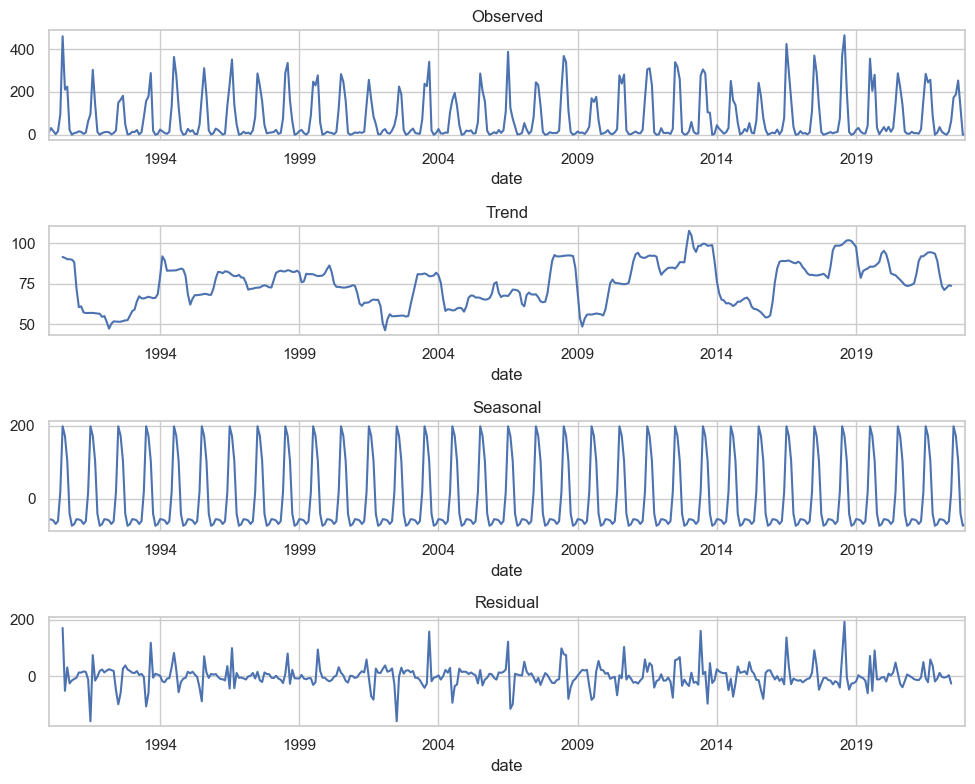

In [21]:
# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

<h2> Let's make some Models </h2>

In [22]:
#Prepare Target
Y = data['Rain_mm']
#Y

#Prepare features

features = list(data.select_dtypes(include = np.number).columns)
#features.remove('Rain_mm')
# Features to remove
to_remove = ['Rain_mm','day','year', 'month']

# Removing non-feature cols from list
features = [f for f in features if f not in to_remove]

#print(features)
#Features to exog (For Sarimax)
exog = data[features]

<h3>1. SARIMAX Model </h3>
SARIMA extends ARIMA's capabilities to handle seasonal patterns.
SARIMAX further enhances the model's predictive accuracy by incorporating exogenous variables.
X= Multivariate

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
# Parameter definition for best model selection, we will use AIC as model metric - lesser the better

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#Initiate AIC Score

AIC_scores_list = []

#pdq
#seasonal_pdq

In [25]:
#Run all the combinations to find the best fit
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        temp_model = SARIMAX(Y,exog=exog,order = param,seasonal_order = param_seasonal, enforce_stationarity=True, enforce_invertibility=True)
        results = temp_model.fit()
        l = []
        l.append(param[0])
        l.append(param[1])
        l.append(param[2])
        l.append(param_seasonal[0])
        l.append(param_seasonal[1])
        l.append(param_seasonal[2])
        l.append(param_seasonal[3])
        l.append(results.aic)
        AIC_scores_list.append(l)
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
      

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self.

J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so infer

J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so infer

J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so infer

Best SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 model - AIC:3688.961042153932


J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
#Best model per last RUN: Best SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 model - AIC:3689.0420654543386


AIC_scores = pd.DataFrame.from_records(AIC_scores_list)
AIC_scores.columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'AIC']
AIC_scores.iloc[AIC_scores['AIC'].argmin()]

p         1.000000
d         1.000000
q         1.000000
P         0.000000
D         1.000000
Q         1.000000
s        12.000000
AIC    3688.961042
Name: 59, dtype: float64

In [27]:
#See more AIC Details
AIC_scores.head(10)

,p,d,q,P,D,Q,s,AIC
0,0,0,0,0,0,0,12,5959.356574
1,0,0,0,0,0,1,12,3978.815216
2,0,0,0,0,1,0,12,3867.553978
3,0,0,0,0,1,1,12,3702.152431
4,0,0,0,1,0,0,12,3974.839772
5,0,0,0,1,0,1,12,3963.453628
6,0,0,0,1,1,0,12,3771.757969
7,0,0,0,1,1,1,12,3704.063410
8,0,0,1,0,0,0,12,3983.967866
9,0,0,1,0,0,1,12,3978.087918


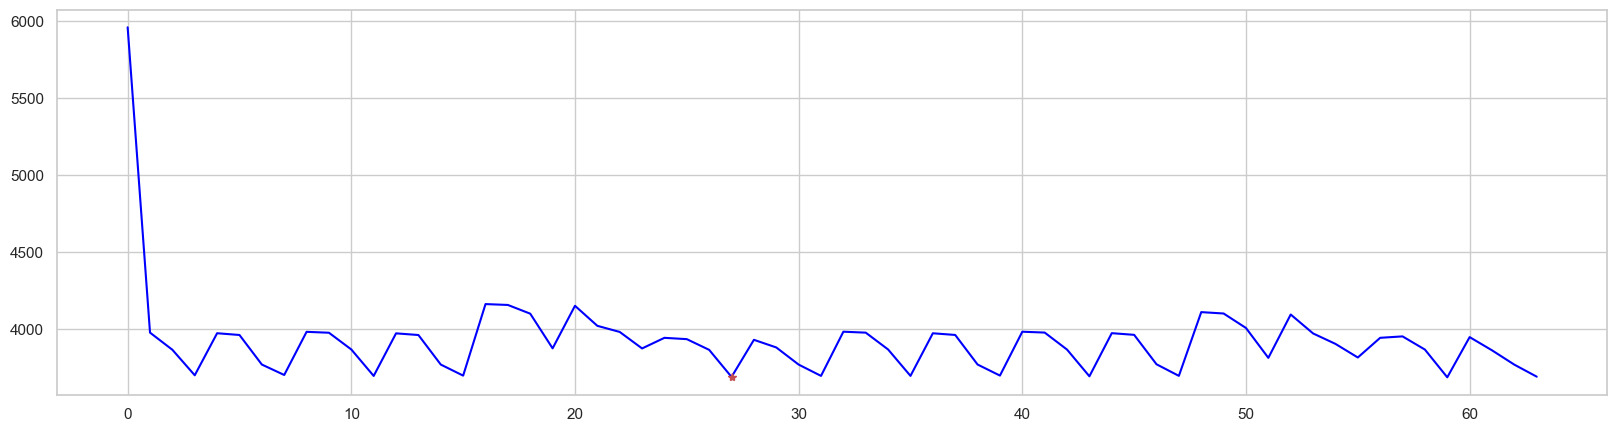

In [28]:
plt.figure(figsize=(20,5))
plt.plot(AIC_scores.AIC, color='blue')
plt.plot(27, AIC_scores.AIC[27], 'r*')

In [29]:
print(best_pdq)
print(best_seasonal_pdq)

(1, 1, 1)
(0, 1, 1, 12)


<h3>AIC Analysis: Best Model Selection</h3>
After fitting the data with different combination of models, we got the best parameters as following:

    * p = 1, d = 1, q = 1
    * P = 0, D = 1, Q = 1
    * s = 12

<h3> Run Best Model </h3>

In [30]:
best_model = SARIMAX(Y,
                     exog=exog,
                     order = best_pdq,
                     seasonal_order = best_seasonal_pdq, 
                     enforce_stationarity=True, 
                     enforce_invertibility=True)
results = best_model.fit()

J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
J:\anaconda3\envs\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
#See results
print(results.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                            Rain_mm   No. Observations:                  396
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1831.481
Date:                            Tue, 24 Sep 2024   AIC                           3688.961
Time:                                    11:51:38   BIC                           3740.285
Sample:                                01-01-1990   HQIC                          3709.321
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         


In [32]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [33]:
y_pred = pred_dynamic.predicted_mean

In [34]:
y_test = Y['2014':]

In [35]:
import math
rmse = math.sqrt(((y_pred - y_test) ** 2).mean())
print('The Mean Squared Error of our predictions is {}'.format(round(rmse, 4)))

#Last run RMSE: The Mean Squared Error of our predictions is 30.3417

The Mean Squared Error of our predictions is 30.205


In [36]:
# rmse = math.sqrt(mean_squared_error(y_test, y_pred))
# rmse

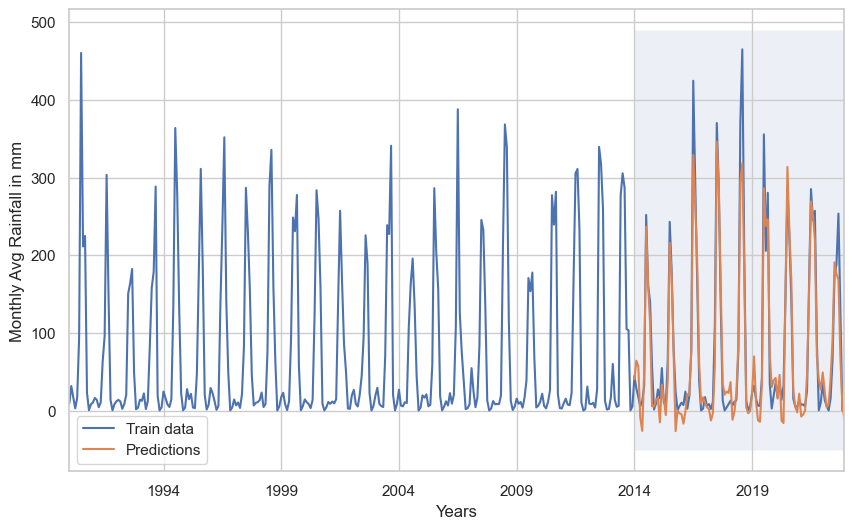

In [37]:
# Plot the actual values.
axis_plt = Y['1985':].plot(label='Train data', figsize=(10, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Predictions')

# Plot confidence values and fill it with some colour.
# axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('2014'), Y.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly Avg Rainfall in mm')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')

Try XGBOOST

In [38]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [39]:
#Split Test train
train = data[:'2014']
test = data['2014':]

#Training dataset
y_train = train["Rain_mm"]
X_train = train.drop("Rain_mm", axis=1)

#Testing dataset
y_test = test["Rain_mm"]
X_test = test.drop("Rain_mm", axis=1)

In [40]:
#Create XGB

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

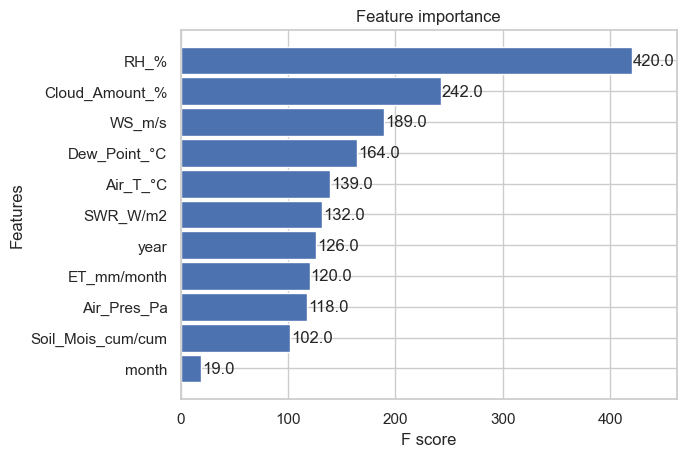

In [41]:
#Feature Importance
_ = plot_importance(reg, height=0.9)

In [42]:
#Run XGB on test set
y_pred = reg.predict(X_test)

In [43]:
#Saving Predicted values to Pred df for ease of calculations/ visualization
pred = pd.DataFrame(index=y_test.index)
pred = pred.assign(Rain_mm=(y_pred))
#pred

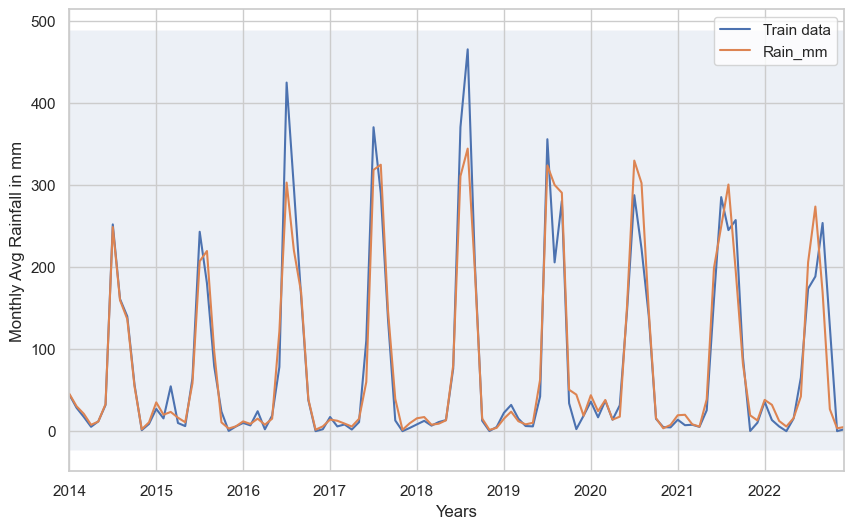

In [44]:
# Plot the actual values.
axis_plt = y_test.plot(label='Train data', figsize=(10, 6))

# Plot the predicted values.
pred.plot(ax=axis_plt, label='Predictions')

# Plot confidence values and fill it with some colour.
# axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('2014'), Y.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly Avg Rainfall in mm')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')

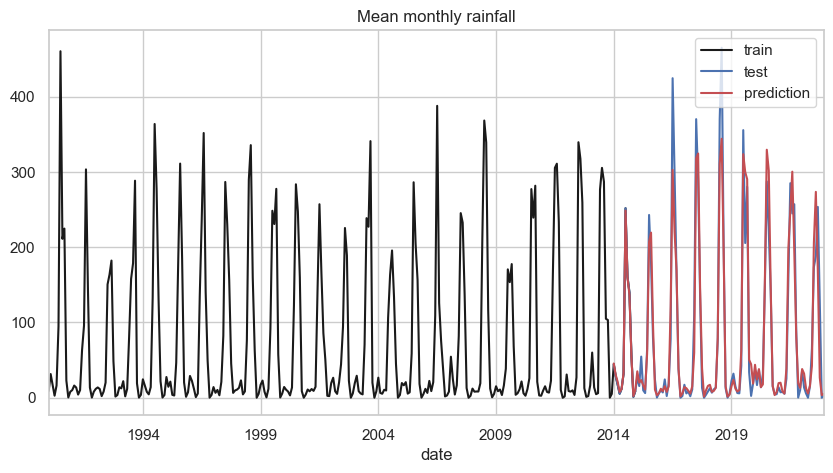

In [45]:
test['Rainfall_Prediction'] = reg.predict(X_test)

train['Rain_mm'].plot(style='k', figsize=(10,5), label = 'train')
test['Rain_mm'].plot(style='b', figsize=(10,5), label = 'test')
test['Rainfall_Prediction'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('Mean monthly rainfall')
plt.legend()

In [46]:
print('RMSE: ', round(mean_squared_error(y_true=test['Rain_mm'],y_pred=test['Rainfall_Prediction']),3))
print('MAE: ', round(mean_absolute_error(y_true=test['Rain_mm'],y_pred=test['Rainfall_Prediction']),3))
print('MAPE: ', round(mean_absolute_percentage_error(y_true=test['Rain_mm'],y_pred=test['Rainfall_Prediction']),3))

RMSE:  1028.738
MAE:  17.679
MAPE:  4.749


In [49]:
test.to_csv("xgb_test.csv")